# Which one is a better plan?

The company offers its clients two prepaid plans, Surf and Ultimate. The commercial department wants to know which of the plans brings in more revenue in order to adjust the advertising budget.

will carry out a preliminary analysis of the plans based on a relatively small client selection. will have the data on 500 Megaline clients: who the clients are, where they're from, which plan they use, and the number of calls they made and text messages they sent in 2018. will analyze the clients' behavior and determine which prepaid plan brings in more revenue.

## Initialization

In [59]:
# Loading all the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import seaborn as sns
from functools import reduce
import datetime
import math
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

## Load data

In [114]:
# Load the data files into different DataFrames
try:
    calls = pd.read_csv('/datasets/megaline_calls.csv')
    internet = pd.read_csv('/datasets/megaline_internet.csv')
    messages = pd.read_csv('/datasets/megaline_messages.csv')
    plans = pd.read_csv('/datasets/megaline_plans.csv')
    users = pd.read_csv('/datasets/megaline_users.csv')
except:
    print('Wrong file')

In [115]:
calls.duplicated().sum()
internet.duplicated().sum()
messages.duplicated().sum()
plans.duplicated().sum()
users.duplicated().sum()

0

0

0

0

0

## Plans

In [116]:
plans.info()
print('')
plans.describe()
plans.describe(include = 'object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes



,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute
count,2.000000,2.000000,2.000000,2.000000,2.00000,2.000000,2.000000
mean,525.000000,23040.000000,1750.000000,45.000000,8.50000,0.020000,0.020000
std,671.751442,10861.160159,1767.766953,35.355339,2.12132,0.014142,0.014142
min,50.000000,15360.000000,500.000000,20.000000,7.00000,0.010000,0.010000
25%,287.500000,19200.000000,1125.000000,32.500000,7.75000,0.015000,0.015000
50%,525.000000,23040.000000,1750.000000,45.000000,8.50000,0.020000,0.020000
75%,762.500000,26880.000000,2375.000000,57.500000,9.25000,0.025000,0.025000
max,1000.000000,30720.000000,3000.000000,70.000000,10.00000,0.030000,0.030000


,plan_name
count,2
unique,2
top,surf
freq,1


In [63]:
plans.head()

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


## Enrich data

In [64]:
def what_plan(plan_name):
    if plan_name == 'ultimate':
        return 1
    if plan_name == 'surf':
        return 0
plans['what_plan'] = plans['plan_name'].apply(what_plan)
plans

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,what_plan
0,50,15360,500,20,10,0.03,0.03,surf,0
1,1000,30720,3000,70,7,0.01,0.01,ultimate,1


<div class="alert alert-info"> <b>
    I added a column to categorize the user's plan, if its surf the function will return 0, and ultimate is 1.

## Users

In [65]:
users.info()
print('')
users.describe()
users.describe(include = 'object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB



,user_id,age
count,500.000000,500.000000
mean,1249.500000,45.486000
std,144.481833,16.972269
min,1000.000000,18.000000
25%,1124.750000,30.000000
50%,1249.500000,46.000000
75%,1374.250000,61.000000
max,1499.000000,75.000000


,first_name,last_name,city,reg_date,plan,churn_date
count,500,500,500,500,500,34
unique,458,399,73,266,2,29
top,Seymour,Mclean,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-11-29,surf,2018-12-18
freq,3,3,80,5,339,3


<div class="alert alert-info"> <b> 
    here we can see that there are a lot of missing values in the churn_date column, i will check later what is the best option to fill it with.
    we can see there is a difference between the first_name values and last_name values, there is more values in the last_name, maybe because there are some users were registered with only the first name.

In [66]:
users.head()

users.tail()

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN


,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
495,1495,Fidel,Sharpe,67,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-09-04,surf,NaN
496,1496,Ariel,Shepherd,49,"New Orleans-Metairie, LA MSA",2018-02-20,surf,NaN
497,1497,Donte,Barrera,49,"Los Angeles-Long Beach-Anaheim, CA MSA",2018-12-10,ultimate,NaN
498,1498,Scot,Williamson,51,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-02-04,surf,NaN
499,1499,Shena,Dickson,37,"Orlando-Kissimmee-Sanford, FL MSA",2018-05-06,surf,NaN


<div class="alert alert-info"> <b> 
    it looks okay with the most of the data, some columns need a type change so the calculations and information we show would be better to read and understand

### Fix Data

In [67]:
users['reg_date'] = pd.to_datetime(users['reg_date'])
users['churn_date'].describe(datetime_is_numeric=True)
users['churn_date'] = users['churn_date'].fillna(value='2035-12-31')
users['churn_date'] = pd.to_datetime(users['churn_date'])

count             34
unique            29
top       2018-12-18
freq               3
Name: churn_date, dtype: object

<div class="alert alert-info"> <b>
    filled in missing values in the churn_date column with a specific value date, maybe the values there we missing because the users used the calls plan (talked by phone) while the data was extracted.
    I chose to fill the missing values with the last day of the same year because users wouldn't leave the contract before the end of the year.

In [68]:
users['what_plan_users'] = users['plan'].apply(what_plan)

users.head()
users.info()

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,what_plan_users
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,2035-12-31,1
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,2035-12-31,0
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,2035-12-31,0
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,2035-12-31,0
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,2035-12-31,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   user_id          500 non-null    int64         
 1   first_name       500 non-null    object        
 2   last_name        500 non-null    object        
 3   age              500 non-null    int64         
 4   city             500 non-null    object        
 5   reg_date         500 non-null    datetime64[ns]
 6   plan             500 non-null    object        
 7   churn_date       500 non-null    datetime64[ns]
 8   what_plan_users  500 non-null    int64         
dtypes: datetime64[ns](2), int64(3), object(4)
memory usage: 35.3+ KB


## Calls

In [69]:
calls.info()
print('')
calls.describe()
calls.describe(include = 'object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB



,user_id,duration
count,137735.000000,137735.000000
mean,1247.658046,6.745927
std,139.416268,5.839241
min,1000.000000,0.000000
25%,1128.000000,1.290000
50%,1247.000000,5.980000
75%,1365.000000,10.690000
max,1499.000000,37.600000


,id,call_date
count,137735,137735
unique,137735,351
top,1277_643,2018-12-27
freq,1,1091


<div class="alert alert-info"> <b> 
    here in the calls data we can see when i called the info method that the call_date columns has an object type, need to change it to datetime type.

In [70]:
calls.head()

calls.tail()

,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22


,id,user_id,call_date,duration
137730,1499_199,1499,2018-11-21,8.72
137731,1499_200,1499,2018-10-20,10.89
137732,1499_201,1499,2018-09-21,8.12
137733,1499_202,1499,2018-10-10,0.37
137734,1499_203,1499,2018-12-29,13.86


### Fix data

In [117]:
calls['call_date'] = pd.to_datetime(calls['call_date'])
calls['duration'] = [math.ceil(number) for number in calls['duration']]
calls['duration'] = calls['duration'].astype(int)
calls.info()
calls.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         137735 non-null  object        
 1   user_id    137735 non-null  int64         
 2   call_date  137735 non-null  datetime64[ns]
 3   duration   137735 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 4.2+ MB


,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,9
1,1000_145,1000,2018-12-27,14
2,1000_247,1000,2018-12-27,15
3,1000_309,1000,2018-12-28,6
4,1000_380,1000,2018-12-30,5


## Messages

In [72]:
messages.info()
print('')
messages.describe()
messages.describe(include = 'object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB



,user_id
count,76051.000000
mean,1245.972768
std,139.843635
min,1000.000000
25%,1123.000000
50%,1251.000000
75%,1362.000000
max,1497.000000


,id,message_date
count,76051,76051
unique,76051,351
top,1382_160,2018-12-28
freq,1,702


In [73]:
messages.head()

messages.tail()

,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26


,id,user_id,message_date
76046,1497_526,1497,2018-12-24
76047,1497_536,1497,2018-12-24
76048,1497_547,1497,2018-12-31
76049,1497_558,1497,2018-12-24
76050,1497_613,1497,2018-12-23


### Fix data

In [74]:
messages['message_date'] = pd.to_datetime(messages['message_date'])# converting the columns type

messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            76051 non-null  object        
 1   user_id       76051 non-null  int64         
 2   message_date  76051 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.7+ MB


## Internet

In [75]:
internet.info()
print('')
messages.describe()
messages.describe(include = 'object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB



,user_id
count,76051.000000
mean,1245.972768
std,139.843635
min,1000.000000
25%,1123.000000
50%,1251.000000
75%,1362.000000
max,1497.000000


,id
count,76051
unique,76051
top,1382_160
freq,1


In [76]:
internet.head()

internet.tail()

,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22


,id,user_id,session_date,mb_used
104820,1499_215,1499,2018-10-20,218.06
104821,1499_216,1499,2018-12-30,304.72
104822,1499_217,1499,2018-09-22,292.75
104823,1499_218,1499,2018-12-07,0.00
104824,1499_219,1499,2018-12-24,758.31


### Fix data

In [77]:
m_to_g = 0.00097 # would be easier to look also on the data with gigabytes if needed
internet['session_date'] = pd.to_datetime(internet['session_date'])

### Enrich data

In [78]:
internet['use_per_month'] = internet['session_date'].dt.month
used_internet = internet.pivot_table(index=['user_id', 'use_per_month'], values='mb_used', aggfunc='sum')
used_internet['gb_used'] = used_internet['mb_used'] * m_to_g # turning to gigabytes
used_internet['gb_used'] = [math.ceil(number) for number in used_internet['gb_used']] #rounding up
used_internet['gb_used'] = used_internet['gb_used'].astype(int)

internet.info()

internet.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   id             104825 non-null  object        
 1   user_id        104825 non-null  int64         
 2   session_date   104825 non-null  datetime64[ns]
 3   mb_used        104825 non-null  float64       
 4   use_per_month  104825 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 4.0+ MB


,id,user_id,session_date,mb_used,use_per_month
0,1000_13,1000,2018-12-29,89.86,12
1,1000_204,1000,2018-12-31,0.00,12
2,1000_379,1000,2018-12-28,660.40,12
3,1000_413,1000,2018-12-26,270.99,12
4,1000_442,1000,2018-12-27,880.22,12


<div class="alert alert-info"> <b>
    will check for outlires

In [79]:
calls.query('duration == 0')
internet.query('mb_used == 0')
users.query('age < 18')

,id,user_id,call_date,duration
19,1001_4,1001,2018-12-05,0
25,1001_13,1001,2018-12-24,0
31,1001_30,1001,2018-10-17,0
32,1001_31,1001,2018-11-03,0
34,1001_35,1001,2018-12-21,0
...,...,...,...,...
137714,1499_183,1499,2018-11-10,0
137715,1499_184,1499,2018-09-15,0
137720,1499_189,1499,2018-12-27,0
137722,1499_191,1499,2018-12-24,0


,id,user_id,session_date,mb_used,use_per_month
1,1000_204,1000,2018-12-31,0.0,12
14,1001_26,1001,2018-09-17,0.0,9
16,1001_28,1001,2018-10-17,0.0,10
34,1001_54,1001,2018-09-02,0.0,9
43,1001_77,1001,2018-10-31,0.0,10
...,...,...,...,...,...
104797,1499_192,1499,2018-09-19,0.0,9
104804,1499_199,1499,2018-12-09,0.0,12
104816,1499_211,1499,2018-09-26,0.0,9
104817,1499_212,1499,2018-09-11,0.0,9


,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,what_plan_users


<div class="alert alert-info"> <b>
    there are some of them, about the duration calls (0) maybe it was a missing call for the same user or answered by wrong (when the phone is in your pocket and press the answer bottum by wrong). 
    about users who doesnt use internet maybe they are connected to a wi fi net or something else.
    no underage users in the dataframe

## Study plan conditions

In [80]:
plans.describe()
plans.describe(include='object')
plans['usd_monthly_pay'].describe()
plans['usd_per_gb'].describe()


,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,what_plan
count,2.000000,2.000000,2.000000,2.000000,2.00000,2.000000,2.000000,2.000000
mean,525.000000,23040.000000,1750.000000,45.000000,8.50000,0.020000,0.020000,0.500000
std,671.751442,10861.160159,1767.766953,35.355339,2.12132,0.014142,0.014142,0.707107
min,50.000000,15360.000000,500.000000,20.000000,7.00000,0.010000,0.010000,0.000000
25%,287.500000,19200.000000,1125.000000,32.500000,7.75000,0.015000,0.015000,0.250000
50%,525.000000,23040.000000,1750.000000,45.000000,8.50000,0.020000,0.020000,0.500000
75%,762.500000,26880.000000,2375.000000,57.500000,9.25000,0.025000,0.025000,0.750000
max,1000.000000,30720.000000,3000.000000,70.000000,10.00000,0.030000,0.030000,1.000000


,plan_name
count,2
unique,2
top,surf
freq,1


count     2.000000
mean     45.000000
std      35.355339
min      20.000000
25%      32.500000
50%      45.000000
75%      57.500000
max      70.000000
Name: usd_monthly_pay, dtype: float64

count     2.00000
mean      8.50000
std       2.12132
min       7.00000
25%       7.75000
50%       8.50000
75%       9.25000
max      10.00000
Name: usd_per_gb, dtype: float64

## Aggregate data per user

In [118]:
calls['use_per_month'] = pd.to_datetime(calls['call_date'])
monthly_calls = calls.groupby(['user_id', 'use_per_month']).use_per_month.count()
monthly_calls.head()

calls.info()

user_id  use_per_month
1000     2018-12-26       2
         2018-12-27       5
         2018-12-28       4
         2018-12-29       1
         2018-12-30       1
Name: use_per_month, dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   id             137735 non-null  object        
 1   user_id        137735 non-null  int64         
 2   call_date      137735 non-null  datetime64[ns]
 3   duration       137735 non-null  int64         
 4   use_per_month  137735 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 5.3+ MB


In [82]:
calls['use_per_month'] = calls['call_date'].dt.month
calls_length = calls.pivot_table(index=['use_per_month','user_id'], values='duration', aggfunc=('sum', 'count')).reset_index()
calls_length.head()

,use_per_month,user_id,count,sum
0,1,1042,18,114
1,1,1077,42,290
2,1,1185,23,181
3,1,1196,42,287
4,1,1214,5,16


In [83]:
messages['use_per_month'] = messages['message_date'].dt.month
monthly_sent_messages = messages.groupby(['user_id', 'use_per_month']).message_date.count()
monthly_sent_messages


user_id  use_per_month
1000     12               11
1001     8                30
         9                44
         10               53
         11               36
                          ..
1496     9                21
         10               18
         11               13
         12               11
1497     12               50
Name: message_date, Length: 1806, dtype: int64

In [84]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             76051 non-null  object        
 1   user_id        76051 non-null  int64         
 2   message_date   76051 non-null  datetime64[ns]
 3   use_per_month  76051 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 2.3+ MB


In [85]:
used_internet.head()
used_internet.tail()



mb_used  gb_used
user_id use_per_month                   
1000    12              1901.47        2
1001    8               6919.15        7
        9              13314.82       13
        10             22330.49       22
        11             18504.30       18

mb_used  gb_used
user_id use_per_month                   
1498    12             23137.69       23
1499    9              12984.76       13
        10             19492.43       19
        11             16813.83       17
        12             22059.21       22

In [86]:
all_data = [used_internet, calls_length, monthly_sent_messages]
users_info = reduce(lambda left,right: pd.merge(left, right, on=['user_id', 'use_per_month'],
                                                how='outer'),all_data)
users_info.rename(columns= {"message_date" : "messages"}, inplace = True)
all_data1 = [users_info, users]
users_info = reduce(lambda left,right: pd.merge(left, right, on=['user_id'],
                                                how='outer'), all_data1)
users_info = users_info.fillna(value=0)
users_info.head()

,user_id,use_per_month,mb_used,gb_used,count,sum,messages,first_name,last_name,age,city,reg_date,plan,churn_date,what_plan_users
0,1000,12.0,1901.47,2.0,16.0,124.0,11.0,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,2035-12-31,1
1,1001,8.0,6919.15,7.0,27.0,182.0,30.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,2035-12-31,0
2,1001,9.0,13314.82,13.0,49.0,315.0,44.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,2035-12-31,0
3,1001,10.0,22330.49,22.0,65.0,393.0,53.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,2035-12-31,0
4,1001,11.0,18504.30,18.0,64.0,426.0,36.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,2035-12-31,0


In [89]:
users_info.duplicated().sum()

0

In [90]:
plans

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,what_plan
0,50,15360,500,20,10,0.03,0.03,surf,0
1,1000,30720,3000,70,7,0.01,0.01,ultimate,1


In [91]:
users_info.merge(plans,how='inner',left_on='what_plan_users',right_on='what_plan').columns

Index(['user_id', 'use_per_month', 'mb_used', 'gb_used', 'count', 'sum',
       'messages', 'first_name', 'last_name', 'age', 'city', 'reg_date',
       'plan', 'churn_date', 'what_plan_users', 'messages_included',
       'mb_per_month_included', 'minutes_included', 'usd_monthly_pay',
       'usd_per_gb', 'usd_per_message', 'usd_per_minute', 'plan_name',
       'what_plan'],
      dtype='object')

<div class="alert alert-info"> <b>
    filled in missing values with 0 for those who didnt use the plan then, i used an outer join to avoid duplicates in the data

In [92]:
# Add the plan information
users_plans = users_info.merge(plans,how='outer',left_on='what_plan_users',right_on='what_plan')
users_plans.head()


,user_id,use_per_month,mb_used,gb_used,count,sum,messages,first_name,last_name,age,...,what_plan_users,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,what_plan
0,1000,12.0,1901.47,2.0,16.0,124.0,11.0,Anamaria,Bauer,45,...,1,1000,30720,3000,70,7,0.01,0.01,ultimate,1
1,1006,11.0,2068.37,3.0,2.0,10.0,15.0,Jesusa,Bradford,73,...,1,1000,30720,3000,70,7,0.01,0.01,ultimate,1
2,1006,12.0,32118.82,32.0,9.0,59.0,139.0,Jesusa,Bradford,73,...,1,1000,30720,3000,70,7,0.01,0.01,ultimate,1
3,1008,10.0,17106.99,17.0,71.0,476.0,21.0,Emely,Hoffman,53,...,1,1000,30720,3000,70,7,0.01,0.01,ultimate,1
4,1008,11.0,23676.72,23.0,63.0,446.0,37.0,Emely,Hoffman,53,...,1,1000,30720,3000,70,7,0.01,0.01,ultimate,1


In [93]:
users_plans.head()

,user_id,use_per_month,mb_used,gb_used,count,sum,messages,first_name,last_name,age,...,what_plan_users,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,what_plan
0,1000,12.0,1901.47,2.0,16.0,124.0,11.0,Anamaria,Bauer,45,...,1,1000,30720,3000,70,7,0.01,0.01,ultimate,1
1,1006,11.0,2068.37,3.0,2.0,10.0,15.0,Jesusa,Bradford,73,...,1,1000,30720,3000,70,7,0.01,0.01,ultimate,1
2,1006,12.0,32118.82,32.0,9.0,59.0,139.0,Jesusa,Bradford,73,...,1,1000,30720,3000,70,7,0.01,0.01,ultimate,1
3,1008,10.0,17106.99,17.0,71.0,476.0,21.0,Emely,Hoffman,53,...,1,1000,30720,3000,70,7,0.01,0.01,ultimate,1
4,1008,11.0,23676.72,23.0,63.0,446.0,37.0,Emely,Hoffman,53,...,1,1000,30720,3000,70,7,0.01,0.01,ultimate,1


<div class="alert alert-info"> <b>
    here I created a new variable users_plans and called a merge on the users_info and we can see in the printed table all relevant information we want to know about the users plans. every row presents one user with all information about the same user like: what plan he is currently, how many minutes included, internet and many other important information when we look on the data. 

In [94]:
# Calculate the monthly revenue for each user
def calc_rev(x):
    rev = x['usd_monthly_pay']
    #internet:
    if x['mb_used'] > x['mb_per_month_included']:
        cost = np.ceil(((x['mb_used'] - x['mb_per_month_included'])/1024))*x['usd_per_gb']
        rev +=cost
    #calls:
    if x['sum'] > x['minutes_included']:
        cost = (x['sum'] - x['minutes_included'])*x['usd_per_minute']
        rev +=cost
    #messages:
    if x['messages'] > x['messages_included']:
        cost = (x['messages'] - x['messages_included'])*x['usd_per_message']
        rev +=cost    
    return rev

users_plans['revenue'] = users_plans.apply(calc_rev,axis=1)
users_plans.head()


,user_id,use_per_month,mb_used,gb_used,count,sum,messages,first_name,last_name,age,...,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,what_plan,revenue
0,1000,12.0,1901.47,2.0,16.0,124.0,11.0,Anamaria,Bauer,45,...,1000,30720,3000,70,7,0.01,0.01,ultimate,1,70.0
1,1006,11.0,2068.37,3.0,2.0,10.0,15.0,Jesusa,Bradford,73,...,1000,30720,3000,70,7,0.01,0.01,ultimate,1,70.0
2,1006,12.0,32118.82,32.0,9.0,59.0,139.0,Jesusa,Bradford,73,...,1000,30720,3000,70,7,0.01,0.01,ultimate,1,84.0
3,1008,10.0,17106.99,17.0,71.0,476.0,21.0,Emely,Hoffman,53,...,1000,30720,3000,70,7,0.01,0.01,ultimate,1,70.0
4,1008,11.0,23676.72,23.0,63.0,446.0,37.0,Emely,Hoffman,53,...,1000,30720,3000,70,7,0.01,0.01,ultimate,1,70.0


<div class="alert alert-info"> <b>
    I wrote a function to calculate how much every user will pay, if we want to know the total revenue from the whole users we simply can call the sum() method on the same column I added to the table (revenue) and we get the total revenue. 
    the function returns in basic the default price per each user per plan (with the merged data) if he doesn't pass the limited minutes, gigabytes, number of messages givven in the same plan.  
    for example user 1006 he is in ultimate plan but his bill wasn't 70$ like its supposed to be, because he used 32118.82 megabytes and the ultimate plan includes 30720 megabytes per month so he got charged on more megabytes exceeding the plan limit.

## Study user behaviour

### Calls

In [95]:
ultimate_users = users_plans.query('plan == "ultimate"')
surf_users = users_plans.query('plan == "surf"')

<AxesSubplot:xlabel='plan'>

Text(0.5, 1.0, 'plan duration barplot')

Text(0.5, 0, 'duration')

Text(0, 0.5, 'count')

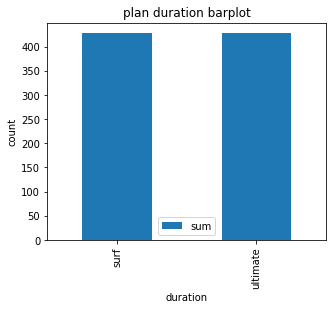

In [96]:
pivot = users_plans.pivot_table(index='plan', values='sum', aggfunc='mean')
pivot.plot(kind='bar', figsize=(5,4))
plt.title('plan duration barplot')
plt.xlabel('duration')
plt.ylabel('count')
plt.show()

array([[<AxesSubplot:title={'center':'sum'}>]], dtype=object)

Text(0.5, 1.0, 'ultimate duration calls')

Text(0.5, 0, 'duration')

Text(0, 0.5, 'count')

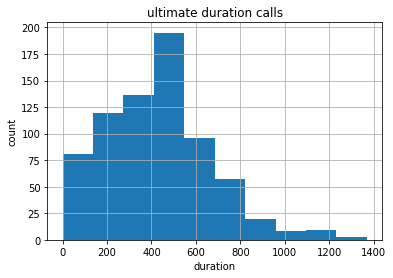

In [97]:
ultimate_users.hist('sum')
plt.title('ultimate duration calls')
plt.xlabel('duration')
plt.ylabel('count')
plt.show()

array([[<AxesSubplot:title={'center':'sum'}>]], dtype=object)

Text(0.5, 1.0, 'surf duration calls')

Text(0.5, 0, 'duration')

Text(0, 0.5, 'count')

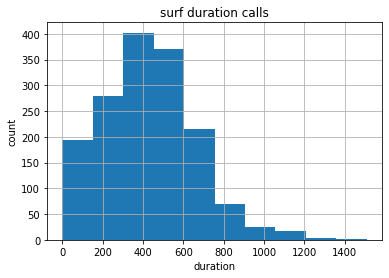

In [98]:
#surf duration calls histogram:
surf_users.hist('sum')
plt.title('surf duration calls')
plt.xlabel('duration')
plt.ylabel('count')
plt.show()

<div class="alert alert-info"> <b>
    two histogram showing the duration calls (minutes talked) in the two plans.
    its obvious that users in surf plan talk more calls, we can see a higher frequency of users who talked between 250 - 600 minutes. 

In [ ]:
# Calculate the mean and the variance of the monthly call duration

#mean:
ultimate_users_mean = ultimate_users['sum'].mean()
surf_users_mean = surf_users['sum'].mean()

#vaariance:
ultimate_users_var = np.var(ultimate_users['sum'])
surf_users_var = np.var(surf_users['sum'])

ultimate_users.pivot_table(index= 'plan', values= 'sum', aggfunc= ['mean', 'var','std', 'median'])
print(f'the mean duration call in ultimate plan is:{ultimate_users_mean}')
print()
print(f'the variance duration call in ultimate plan is:{ultimate_users_var}')
print()

surf_users.pivot_table(index= 'plan', values= 'sum', aggfunc= ['mean', 'var','std', 'median'])
print(f'the mean duration call in surf plan is:{surf_users_mean}')
print()
print(f'the variance duration call in surf plan is:{surf_users_var}')

<div class="alert alert-info"> <b>
    the mean duration call in ultimate plan is a bit higher than the surf plan, but it looks like there is no big difference between both of them.

<AxesSubplot:>

Text(0.5, 1.0, "ultimte duration's boxplot")

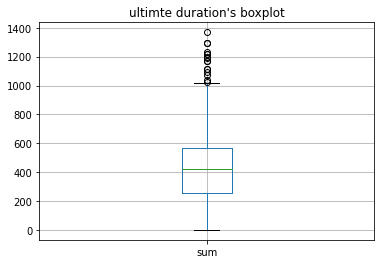

In [100]:
# Plot a boxplot to visualize the distribution of the monthly call duration
#ultimate duration boxplot:
ultimate_users.boxplot('sum')
plt.title('ultimte duration\'s boxplot')
plt.show()

<AxesSubplot:>

Text(0.5, 1.0, "surf duration's boxplot")

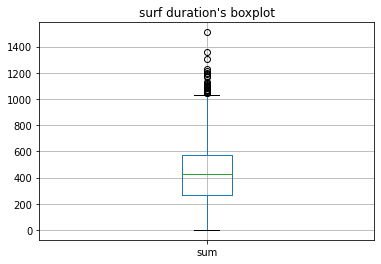

In [101]:
#surf duration boxplot:
surf_users.boxplot('sum')
plt.title('surf duration\'s boxplot')
plt.show()

<div class="alert alert-info"> <b>
    actually looks like both boxplots are almost the same, we can see the average call duration looks similar. both have an outliers, in the surf's plan a bit more.

### Messages

array([[<AxesSubplot:title={'center':'messages'}>]], dtype=object)

Text(0.5, 1.0, 'ultimate messages')

Text(0.5, 0, 'messages')

Text(0, 0.5, 'count')

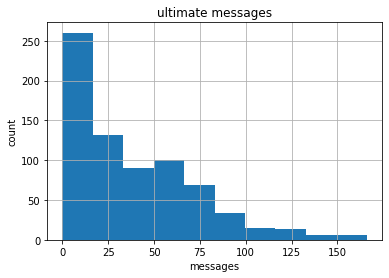

In [102]:
# Compare the number of messages users of each plan tend to send each month
#ultimate histogram:
ultimate_users.hist('messages')
plt.title('ultimate messages')
plt.xlabel('messages')
plt.ylabel('count')
plt.show()


array([[<AxesSubplot:title={'center':'messages'}>]], dtype=object)

Text(0.5, 1.0, 'surf messages')

Text(0.5, 0, 'messages')

Text(0, 0.5, 'count')

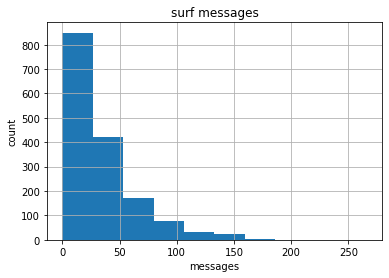

In [103]:
#surf_histogram:
surf_users.hist('messages')
plt.title('surf messages')
plt.xlabel('messages')
plt.ylabel('count')
plt.show()

<div class="alert alert-info"> <b>
    here we can see two histograms showing the frequency of messages seperatly in the two plans. 
    there is a difference between both plans in the range of 0-50 messages, in surf plan has about 800 in the count axis while the ultimate plan has about 250. maybe surf plan users tend to use messages more than ultimate plan users.

### Internet

array([[<AxesSubplot:title={'center':'mb_used'}>]], dtype=object)

Text(0.5, 1.0, 'ultimate internet usage')

Text(0.5, 0, 'mb_used')

Text(0, 0.5, 'count')

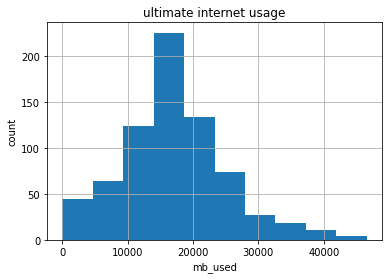

In [104]:
# Compare the amount of internet traffic consumed by users per plan
#ultimate histogram:
ultimate_users.hist('mb_used')
plt.title('ultimate internet usage')
plt.xlabel('mb_used')
plt.ylabel('count')
plt.show()


array([[<AxesSubplot:title={'center':'mb_used'}>]], dtype=object)

Text(0.5, 1.0, 'surf internet usage')

Text(0.5, 0, 'mb_used')

Text(0, 0.5, 'count')

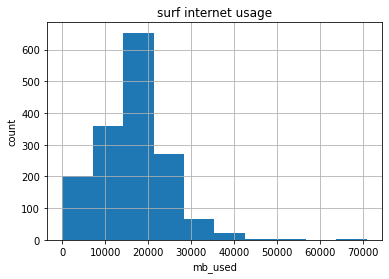

In [105]:
surf_users.hist('mb_used')
plt.title('surf internet usage')
plt.xlabel('mb_used')
plt.ylabel('count')
plt.show()

<div class="alert alert-info"> <b>
    in the internet usage also we can see there is a difference between users behaviors, looks like the surf users uses more while higher frequency of people using between 10000mg - 25000mg.

## Revenue

In [106]:
ultimate_users_rev = ultimate_users['revenue'].mean()
surf_users_rev = surf_users['revenue'].mean()

print(f'the mean revenue in ultimate plan is:{ultimate_users_rev}')
print()
print(f'the mean revenue in surf plan is:{surf_users_rev}')


the mean revenue in ultimate plan is:72.3011049723757

the mean revenue in surf plan is:60.551728942368584


<div class="alert alert-info"> <b>
after plotting some histograms to study the users behaviors, I concluded that the data is similar in the two plans users. while the mean of duration calls was close. usually ultimate users dont exceed their plans limits while there are some users in surf plan would be better for them to take the ultimate plan because if they stay with the same usage in the ultimate plan will pay less than surf plan. 
    the mean revenue of ultimate users is higher than the surf plan, it would be much more profitable for the company with ultimate users, its also not bad with surf users.

## Test statistical hypotheses

<div class="alert alert-info"> <b>
    I assumed that the revenue from the ultimate plan and surf plan will be the same with alpha = 0.05 (5%), and the pvalue we got (the chance this will happen) is lower than the alpha so the hypotheses was rejected and it makes sense because the revenue from both plans is different.

<div class="alert alert-info"> <b>
    the first question : I chose that the null hypotheses will be the fact that both plans - ultimate and surf brings in the same revenue for the company, while the alternative hypotheses will be the fact the revenue from each plan is different than the other. rejected the null hypotheses with p-value smaller than our alpha.

In [107]:
# Test the hypotheses
st.levene(ultimate_users['revenue'], surf_users['revenue'], center='mean')


LeveneResult(statistic=598.0794664776852, pvalue=1.3114884106236739e-117)

In [108]:
ul_rev = ultimate_users['revenue'].mean()

sur_rev = surf_users['revenue'].mean()

print('ultimate mean revenue is:', ul_rev)
print()
print('surf mean revenue is:', sur_rev)

ultimate mean revenue is: 72.3011049723757

surf mean revenue is: 60.551728942368584


In [109]:
alpha = 0.05
test = st.ttest_ind(ultimate_users['revenue'], surf_users['revenue'], equal_var=False)
print(f'the P-value is:{test.pvalue}')
if test.pvalue < alpha:
    print('Reject the null hypotheses')
else:
    print('Don\t reject the null hypotheses')

the P-value is:1.2184115852123163e-15
Reject the null hypotheses


<div class="alert alert-info"> <b>
    I assumed that the revenue from the NY-NJ area and other regions will be the same with alpha = 0.05 (5%), and the pvalue we got (the chance this will happen) is lower than the alpha so the hypotheses was rejected and it makes sense because the revenue from both areas is different.

<div class="alert alert-info"> <b>
    the second question: I chose that the null hypotheses will be the fact that the revenue from NY-NJ area and other regions revenue will be the same, while the alternative hypotheses will be the fact that the revenue from NY-NJ area and other regions area is different. will reject the null hypotheses with smaller p-value than our alpha(5%).

In [110]:
ny_nj_users = users_plans[users_plans['city'].str.contains("NY-NJ")]
ny_nj_users.head(1)

other_regions = users_plans[~users_plans['city'].str.contains("NY-NJ")]
other_regions.head(1)

,user_id,use_per_month,mb_used,gb_used,count,sum,messages,first_name,last_name,age,...,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,what_plan,revenue
30,1031,7.0,10653.04,11.0,36.0,304.0,1.0,Lane,Martin,52,...,1000,30720,3000,70,7,0.01,0.01,ultimate,1,70.0


,user_id,use_per_month,mb_used,gb_used,count,sum,messages,first_name,last_name,age,...,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,what_plan,revenue
0,1000,12.0,1901.47,2.0,16.0,124.0,11.0,Anamaria,Bauer,45,...,1000,30720,3000,70,7,0.01,0.01,ultimate,1,70.0


In [111]:
ny_nj_users_mean = ny_nj_users['revenue'].mean()
other_regions_mean = other_regions['revenue'].mean()

print('NY NJ users mean revenue is:', ny_nj_users_mean)
print()
print('other regions mean revenue is:', other_regions_mean)

NY NJ users mean revenue is: 59.94801587301587

other regions mean revenue is: 65.08926233766233


In [112]:
st.levene(ny_nj_users['revenue'], other_regions['revenue'], center='mean')

LeveneResult(statistic=1.7386932171327514, pvalue=0.18743571504599707)

In [113]:
test_by_region = st.ttest_ind(ny_nj_users['revenue'], other_regions['revenue'], equal_var=False)
print(f'the P-value is:{test_by_region.pvalue}')
if test.pvalue < alpha:
    print('Reject the null hypotheses')
else:
    print('Don\t reject the null hypotheses')

the P-value is:0.03870322661292938
Reject the null hypotheses


## General conclusion

<div class="alert alert-info"> <b> 
    There were five dataframes I worked on in this prject: users, internet, calls, messages and plans. first of all started with checking the data if there are any missing values, duplicates or any other issues to fix, found a big number of missing values in churn_date column and filled them up with the end of the same year. changed some columns types from int \ float or other types to datetime type so there will be an access to the spicific months or days I need for showing the information.
    after fixing all issues plotted some histograms and studied users behaviors and I can conclude that the revenue from the two plans is different, and the same for the NY-NJ area and other regions revenue. people with surf plan tend to use more messaging (we saw a higher frequency in the histogram I plotted before). 
    also conclude that there are some users in surf plan that pay more with the current plan because they exceed their plan limits within its the minutes, messages or internet so it's recommended for them to take the ultimate plan so they will pay less even if they exceed their plan limits.